In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from keplergl import KeplerGl
import math

# 1. Data Cleaning

### 1.1 Load Data: 
###### resource: https://github.com/CSSEGISandData/COVID-19

In [2]:
confirm=pd.read_csv('./data/JHU_CSSE/time_series_19-covid-Confirmed.csv')
recover=pd.read_csv('./data/JHU_CSSE/time_series_19-covid-Recovered.csv')
death=pd.read_csv('./data/JHU_CSSE/time_series_19-covid-Deaths.csv')

In [3]:
print(confirm.shape)
print(recover.shape)
print(death.shape)

(75, 28)
(75, 28)
(75, 28)


In [4]:
confirm['ID']=confirm.index
recover['ID']=recover.index
death['ID']=recover.index

In [5]:
#stack data
confirm_df=pd.DataFrame(confirm.iloc[:,4:28].stack()).reset_index()
recover_df=pd.DataFrame(recover.iloc[:,4:28].stack()).reset_index()
death_df=pd.DataFrame(death.iloc[:,4:28].stack()).reset_index()


confirm_df.rename(columns={'level_1':'time',0:'confirmed'}, inplace=True)
recover_df.rename(columns={'level_1':'time',0:'recover'}, inplace=True)
death_df.rename(columns={'level_1':'time',0:'death'}, inplace=True)

print(confirm_df.shape)
print(recover_df.shape)
print(death_df.shape)

(1800, 3)
(1800, 3)
(1800, 3)


In [6]:
jhk_df=confirm_df.merge(confirm[['Province/State', 'Country/Region', 'Lat', 'Long','ID']], 
                            left_on='level_0',right_on='ID',how='left')
jhk_df['recover']=recover_df['recover']
jhk_df['death']=death_df['death']
jhk_df['time']=pd.to_datetime(jhk_df['time'])
jhk_df

,level_0,time,confirmed,Province/State,Country/Region,Lat,Long,ID,recover,death
0,0,2020-01-22,1,Anhui,Mainland China,31.82571,117.2264,0,0,0
1,0,2020-01-23,9,Anhui,Mainland China,31.82571,117.2264,0,0,0
2,0,2020-01-24,15,Anhui,Mainland China,31.82571,117.2264,0,0,0
3,0,2020-01-25,39,Anhui,Mainland China,31.82571,117.2264,0,0,0
4,0,2020-01-26,60,Anhui,Mainland China,31.82571,117.2264,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1795,74,2020-02-10,0,NaN,Egypt,26.82060,30.8025,74,0,0
1796,74,2020-02-11,0,NaN,Egypt,26.82060,30.8025,74,0,0
1797,74,2020-02-12,0,NaN,Egypt,26.82060,30.8025,74,0,0
1798,74,2020-02-13,0,NaN,Egypt,26.82060,30.8025,74,0,0


In [7]:
jhk_df.to_csv('./data/JHU_CSSE/timeseries_combined.csv')

# 2. SEIR Model
### 2.1 Create S(t), E(t), I(t), R(t), beta for each provindence


In [8]:
#get all population for each province:
pop=pd.read_csv('/Users/yuanfan/Documents/COVID-19/data/province_population.csv')

jhk_df=jhk_df.merge(pop,left_on='Province/State', right_on='province_en', how='left')
jhk_df

,level_0,time,confirmed,Province/State,Country/Region,Lat,Long,ID,recover,death,province_en,pop_18_m,province_cn
0,0,2020-01-22,1,Anhui,Mainland China,31.82571,117.2264,0,0,0,Anhui,63240000.0,安徽
1,0,2020-01-23,9,Anhui,Mainland China,31.82571,117.2264,0,0,0,Anhui,63240000.0,安徽
2,0,2020-01-24,15,Anhui,Mainland China,31.82571,117.2264,0,0,0,Anhui,63240000.0,安徽
3,0,2020-01-25,39,Anhui,Mainland China,31.82571,117.2264,0,0,0,Anhui,63240000.0,安徽
4,0,2020-01-26,60,Anhui,Mainland China,31.82571,117.2264,0,0,0,Anhui,63240000.0,安徽
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18163,74,2020-02-14,1,NaN,Egypt,26.82060,30.8025,74,0,0,NaN,NaN,NaN
18164,74,2020-02-14,1,NaN,Egypt,26.82060,30.8025,74,0,0,NaN,NaN,NaN
18165,74,2020-02-14,1,NaN,Egypt,26.82060,30.8025,74,0,0,NaN,NaN,NaN
18166,74,2020-02-14,1,NaN,Egypt,26.82060,30.8025,74,0,0,NaN,NaN,NaN


In [9]:
progressdf=confirm.iloc[:,4:28]
progressdf.index=confirm['Province/State']
progressdf=progressdf.transpose()
progressdf.head(10)

Province/State,Anhui,Beijing,Chongqing,Fujian,Gansu,Guangdong,Guangxi,Guizhou,Hainan,Hebei,...,NaN,South Australia,"Boston, MA","San Benito, CA",NaN,"Madison, WI",Diamond Princess cruise ship,"San Diego County, CA","San Antonio, TX",NaN
1/22/20,1,14,6,1,0,26,2,1,4,1,...,0,0,0,0,0,0,0,0,0,0
1/23/20,9,22,9,5,2,32,5,3,5,1,...,0,0,0,0,0,0,0,0,0,0
1/24/20,15,36,27,10,2,53,23,3,8,2,...,0,0,0,0,0,0,0,0,0,0
1/25/20,39,41,57,18,4,78,23,4,19,8,...,0,0,0,0,0,0,0,0,0,0
1/26/20,60,68,75,35,7,111,36,5,22,13,...,0,0,0,0,0,0,0,0,0,0
1/27/20,70,80,110,59,14,151,46,7,33,18,...,0,0,0,0,0,0,0,0,0,0
1/28/20,106,91,132,80,19,207,51,9,40,33,...,0,0,0,0,0,0,0,0,0,0
1/29/20,152,111,147,84,24,277,58,9,43,48,...,0,0,0,0,0,0,0,0,0,0
1/30/20,200,114,182,101,26,354,78,12,46,65,...,0,0,0,0,0,0,0,0,0,0
1/31/20,237,139,211,120,29,436,87,29,52,82,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#rolling back the data by SARS rules


exposed=progressdf.shift(periods=-9)-progressdf #this calculate exposed group outside hospital
infectious=progressdf.shift(periods=-3)-progressdf #this calculate infectious group outside hospital
infectious_total=progressdf.shift(periods=-3)


In [11]:
infectious_df=pd.DataFrame(infectious.stack(dropna=False), columns=['infectious_outside']).reset_index()
exposed_df=pd.DataFrame(exposed.stack(dropna=False), columns=['exposed_outside']).reset_index()
infectious_total_df=pd.DataFrame(infectious_total.stack(dropna=False), columns=['infectious_total']).reset_index()

exposed_df.rename(columns={'level_0':'time'}, inplace =True)
infectious_df.rename(columns={'level_0':'time'}, inplace =True)

infectious_df['exposed_outside']=exposed_df['exposed_outside']
infectious_df['infectious_total']=infectious_total_df['infectious_total']
infectious_df['time']=pd.to_datetime(infectious_df['time'])

In [12]:
jhkDF=jhk_df.merge(infectious_df, on=['time','Province/State'],how='left')

jhkDF.head()

,level_0,time,confirmed,Province/State,Country/Region,Lat,Long,ID,recover,death,province_en,pop_18_m,province_cn,infectious_outside,exposed_outside,infectious_total
0,0,2020-01-22,1,Anhui,Mainland China,31.82571,117.2264,0,0,0,Anhui,63240000.0,安徽,38.0,236.0,39.0
1,0,2020-01-23,9,Anhui,Mainland China,31.82571,117.2264,0,0,0,Anhui,63240000.0,安徽,51.0,288.0,60.0
2,0,2020-01-24,15,Anhui,Mainland China,31.82571,117.2264,0,0,0,Anhui,63240000.0,安徽,55.0,325.0,70.0
3,0,2020-01-25,39,Anhui,Mainland China,31.82571,117.2264,0,0,0,Anhui,63240000.0,安徽,67.0,369.0,106.0
4,0,2020-01-26,60,Anhui,Mainland China,31.82571,117.2264,0,0,0,Anhui,63240000.0,安徽,92.0,420.0,152.0


### 2.2 Mobility Data (temp)

### 2.3 Model for each provindence and region

### 2.3.1 Set up Parameters

In [13]:
a=1/7 # 
y=0.135 #recover rate
beta=0.642
gamma = 0.135
R0=4.76
I_w_day0=641 # estimated infection number in Wuhan on Jan.2. 2020
wuhan_population=11080000

### 2.3.2 Define the Model

##### I. Use SEIR to simulate Hubei Internal first ignoring people coming in, this step is to get number of people infected before Jan. 22. This simulation only works before Jan. 31, after that the beta needs to be adjusted

/Users/yuanfan/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


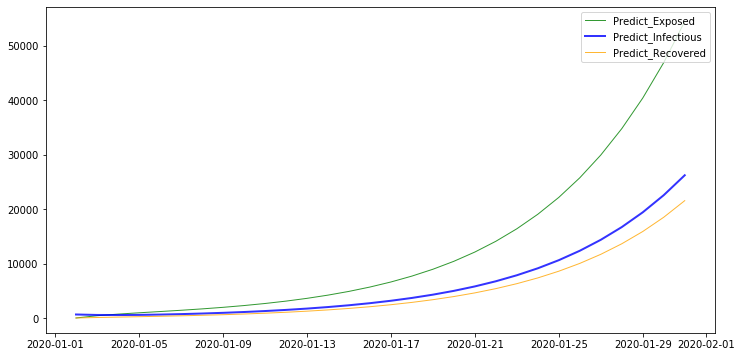

In [14]:
def SEIR_wuhan(currentDF, provinceName, daily_pop_in=0,T=30):
    #df=currentDF[currentDF['province_en']==provinceName].reset_index()
    #N=df.at[0,'pop_18_m']
    N=wuhan_population
    E=[0]
    I=[641]
    R=[0]
    S=[N+daily_pop_in-I[0]-E[0]-R[0]]

    for i in range(T-1):
        susceptic=S[i]-beta*S[i]*I[i]/N-beta*0.5*S[i]*E[i]/N
        exposed=E[i]+beta*S[i]*I[i]/N-a*E[i]

        infectious=I[i]+a*E[i]-y*I[i]
        recover=R[i]+y*I[i]
        S.append(susceptic)
        E.append(exposed)
        I.append(infectious)
        R.append(recover)
    time=pd.date_range(start='1/2/2020', periods=T)
    pred=pd.DataFrame({'pre_susceptics':S,'pre_Exposed':E,'pre_Infectious':I,'pre_Recover':R,'time':time})
    
    fig = plt.figure(figsize=(12,6))

    plt.plot(time,E,marker='', color='green', linewidth=1, alpha=0.8,label='Predict_Exposed')
    plt.plot(time,I,marker='', color='blue', linewidth=2, alpha=0.8,label='Predict_Infectious')
    plt.plot(time,R,marker='', color='orange', linewidth=1, alpha=0.8, label='Predict_Recovered')
    #plt.plot(df['time'],df['infectious'],color='red', linewidth=2,alpha =0.8,label='Actual_Infectious')
    plt.legend(loc='upper right')
    return pred
    
wuhan_simulation=SEIR_wuhan(jhkDF,'wuhan')

##### II. Simulate other Provinces

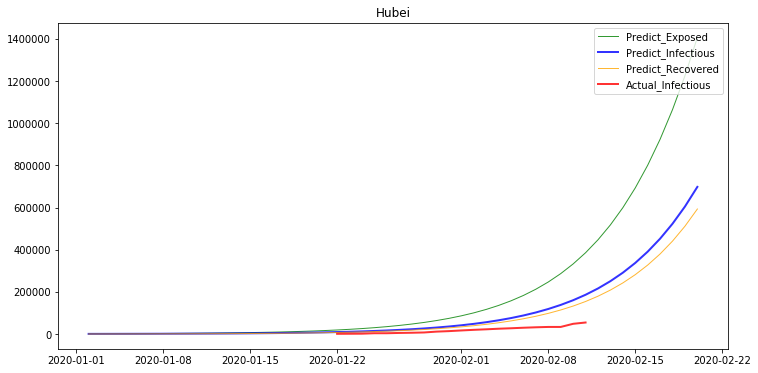

In [21]:
def SEIR(currentDF, provinceName,T=40):
   
    df=currentDF[currentDF['province_en']==provinceName].reset_index()
    
     #get city population
    N=df.at[0,'pop_18_m']

    E=[(df.at[0,'confirmed']+1)*2]# Exposed people, 
    I=[df.at[0,'confirmed']+1]# assume it equals to the number of people got confirmed at 1/22/2020
    R=[0]
    S=[N-I[0]-E[0]-R[0]]
    
    #OD data, we need to simulat this dynamically
    daily_inflow=1/1000 * N # assume there are 1/100 incoming people
    I_inflow=daily_inflow*0.000001

    for i in range(T-1):
        susceptic=S[i]-beta*S[i]*(I[i]+I_inflow)/N-beta*0.5*S[i]*E[i]/N
        exposed=E[i]+beta*S[i]*(I[i]+I_inflow)/N-a*E[i]

        infectious=I[i]+a*E[i]-y*I[i]
        recover=R[i]+y*I[i]
        S.append(susceptic)
        E.append(exposed)
        I.append(infectious)
        R.append(recover)
    time=pd.date_range(start='1/2/2020', periods=T)
    pred=pd.DataFrame({'pre_susceptics':S,'pre_Exposed':E,'pre_Infectious':I,'pre_Recover':R,'time':time})
    
    fig = plt.figure(figsize=(12,6))

    plt.plot(time,E,marker='', color='green', linewidth=1, alpha=0.8,label='Predict_Exposed')
    plt.plot(time,I,marker='', color='blue', linewidth=2, alpha=0.8,label='Predict_Infectious')
    plt.plot(time,R,marker='', color='orange', linewidth=1, alpha=0.8, label='Predict_Recovered')
    plt.plot(df['time'],df['infectious_total'],color='red', linewidth=2,alpha =0.8,label='Actual_Infectious')
    plt.title(provinceName)
    plt.legend(loc='upper right')
    return pred
    
Hubei=SEIR(jhkDF,'Hubei',50)

/Users/yuanfan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


does not exist


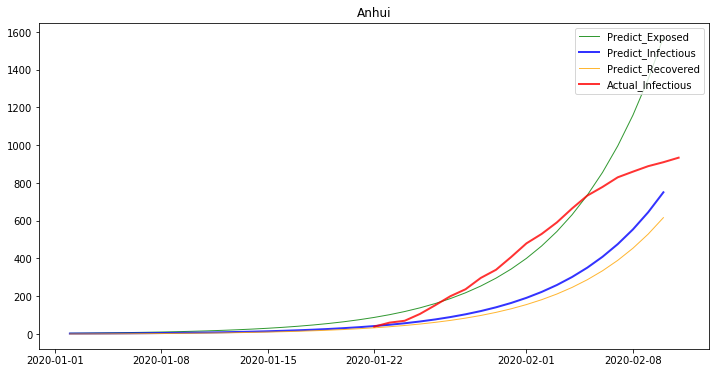

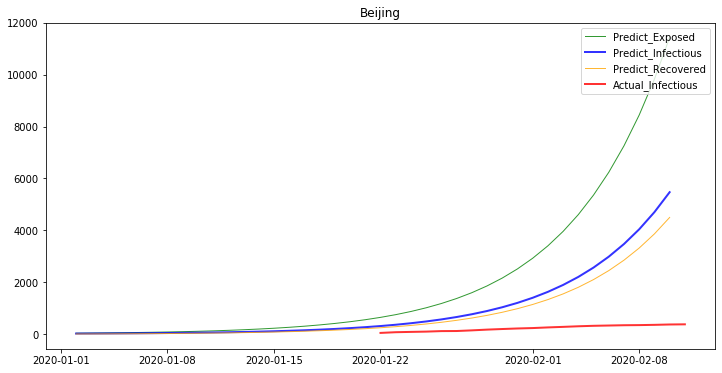

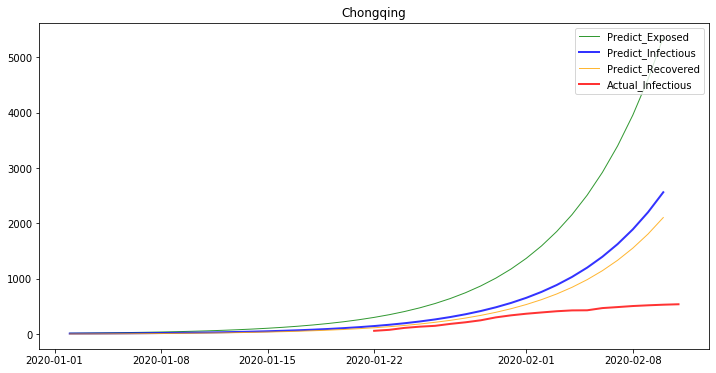

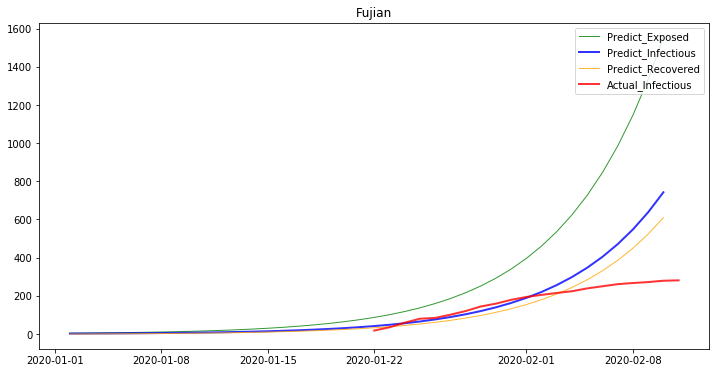

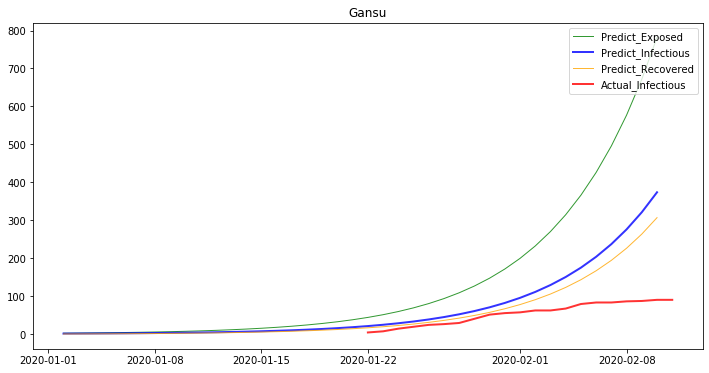

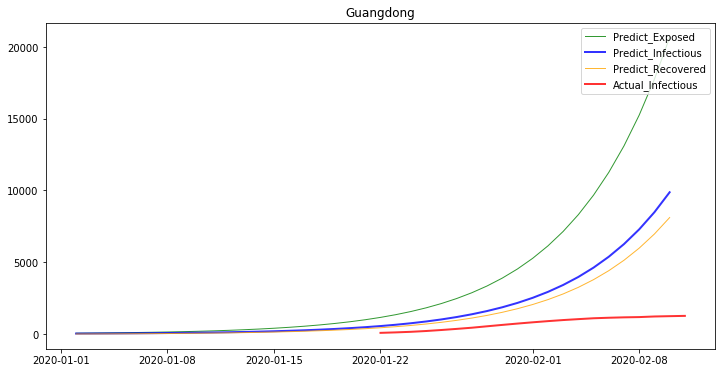

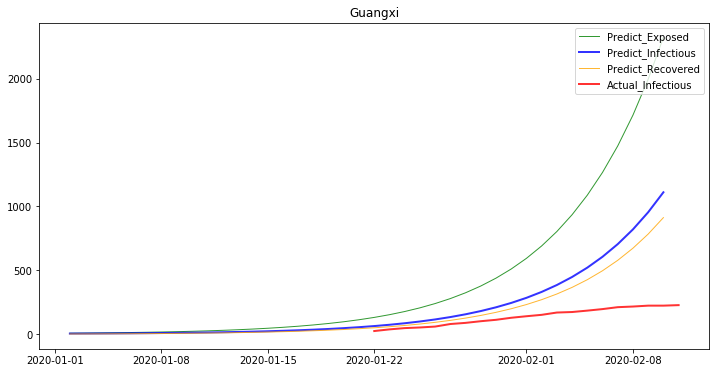

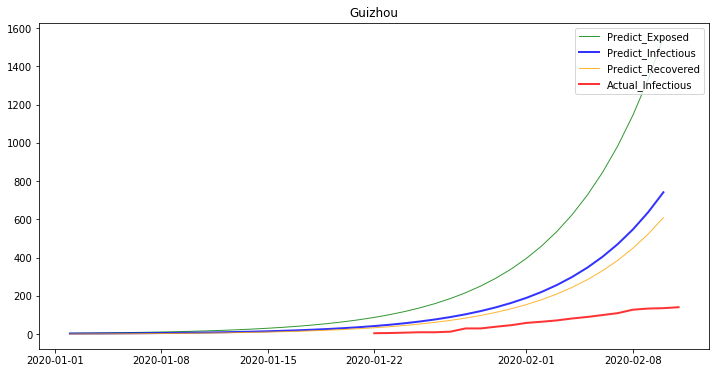

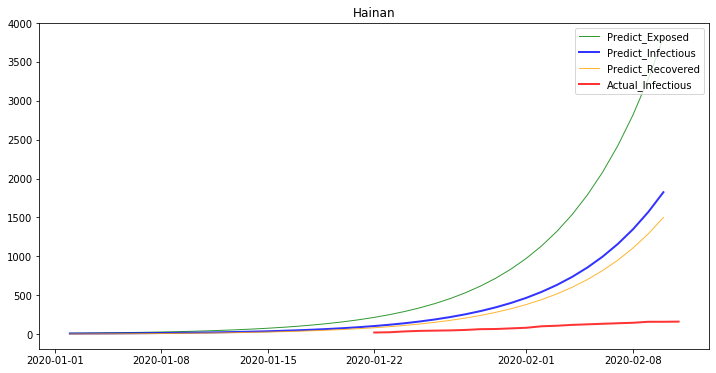

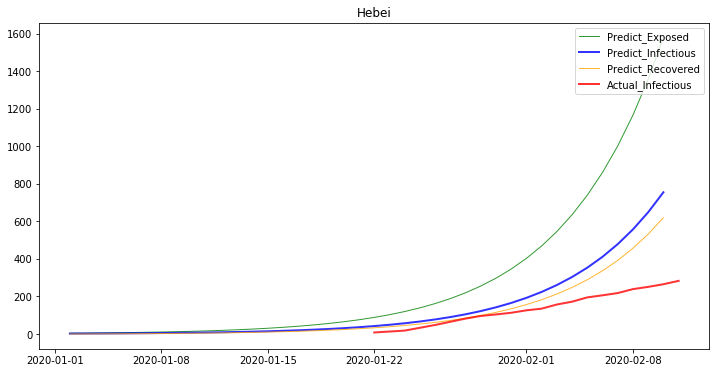

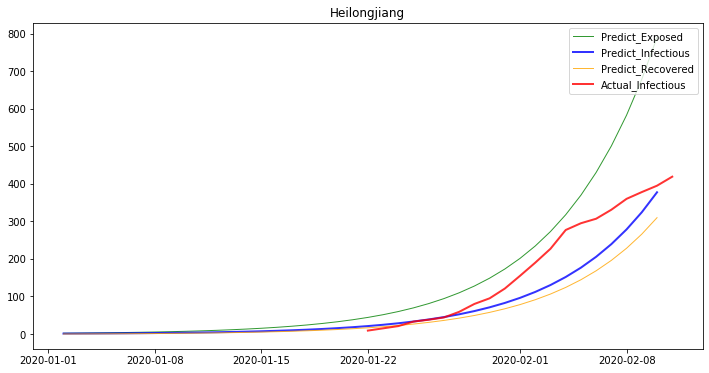

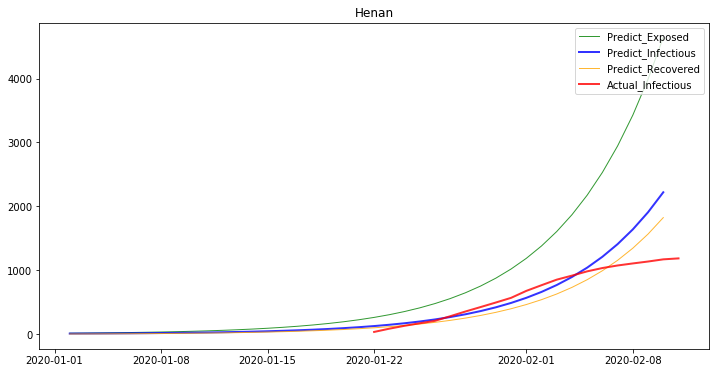

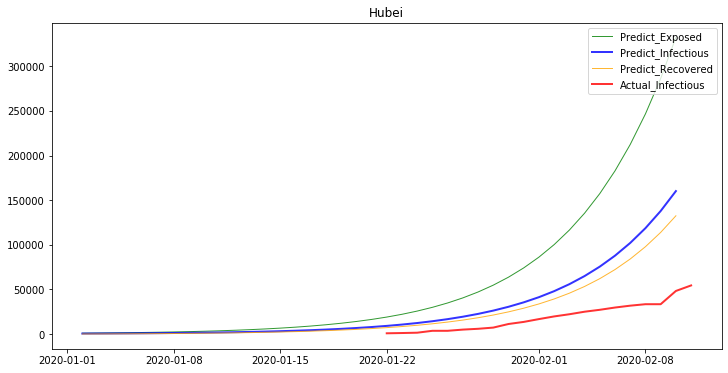

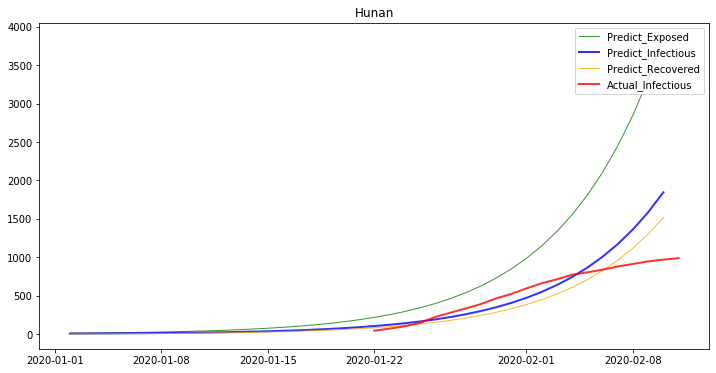

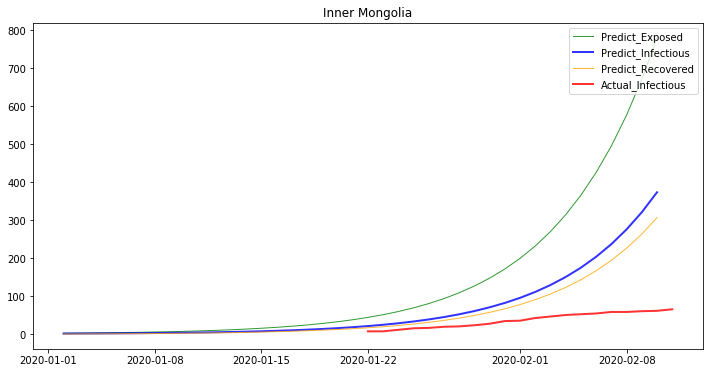

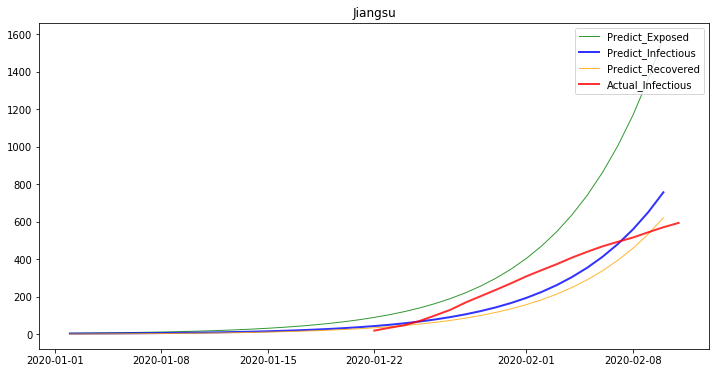

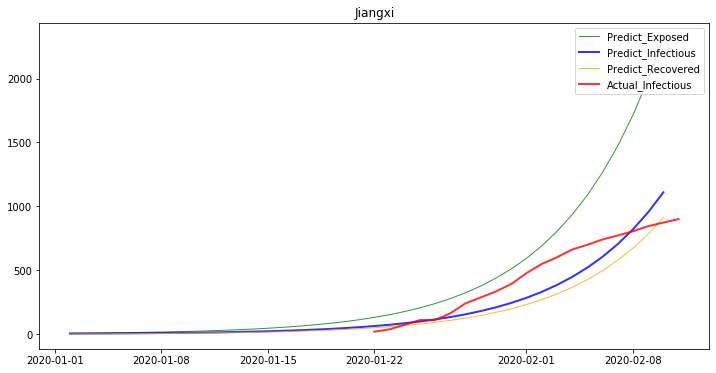

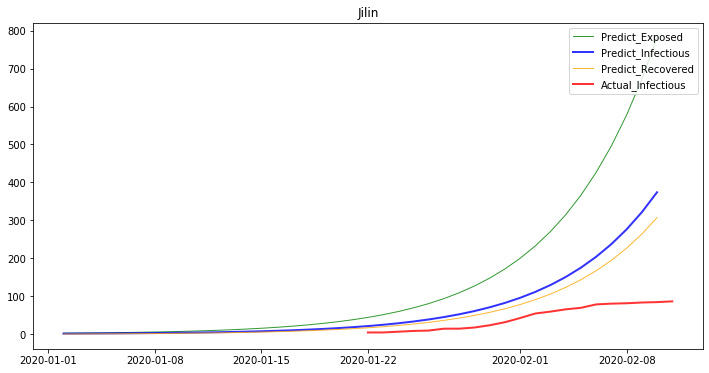

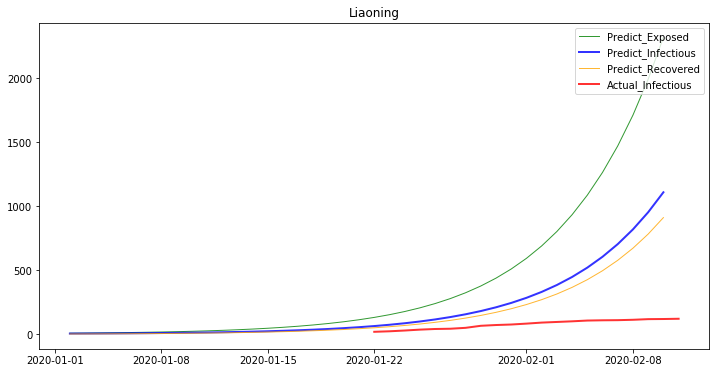

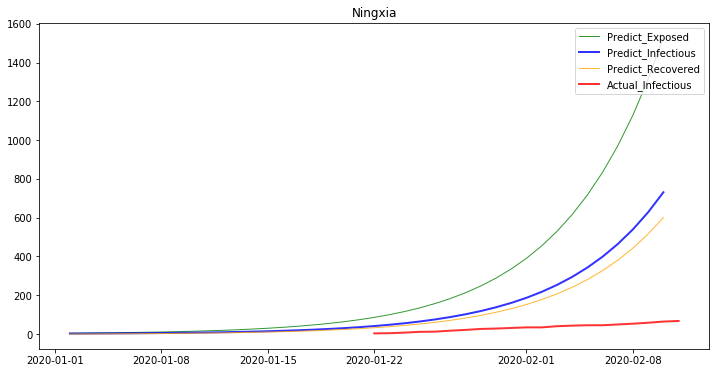

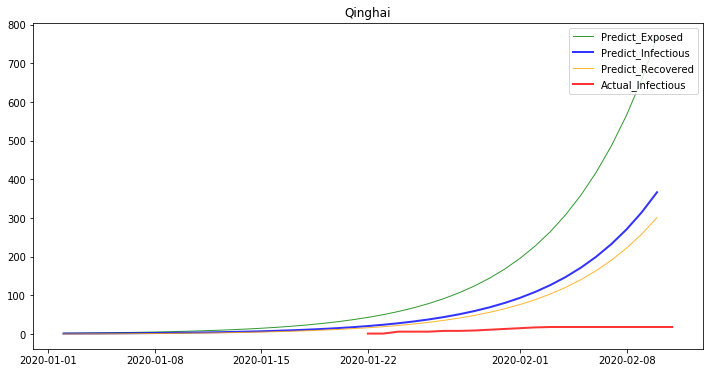

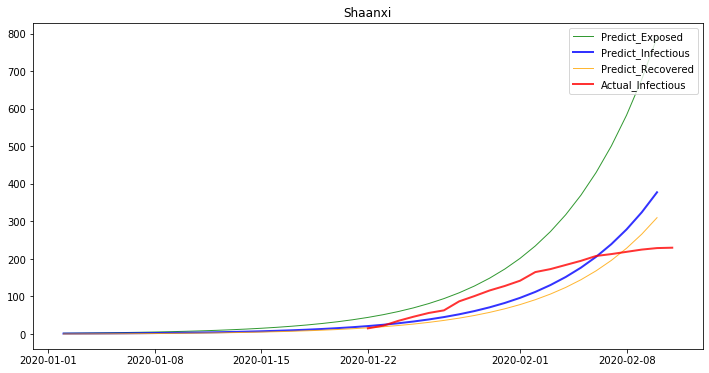

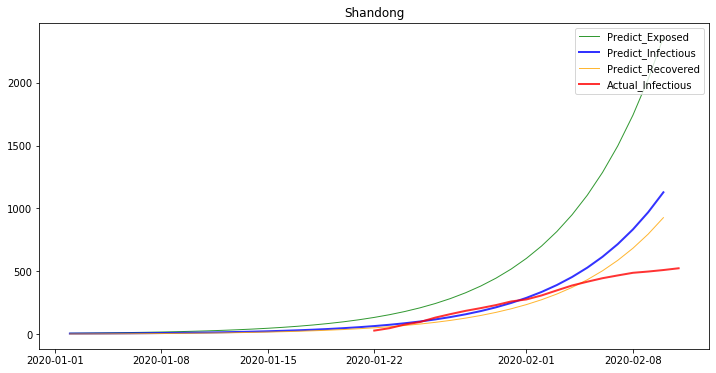

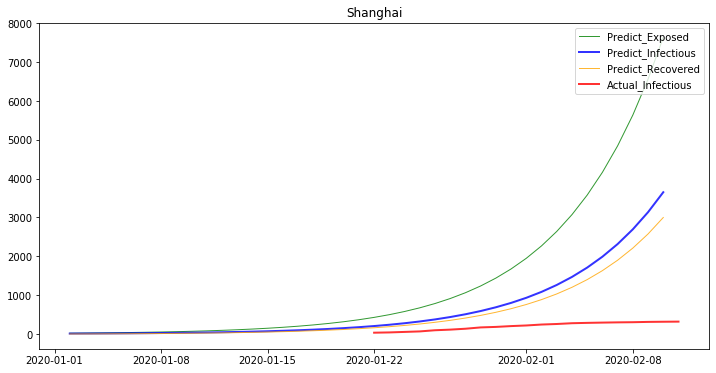

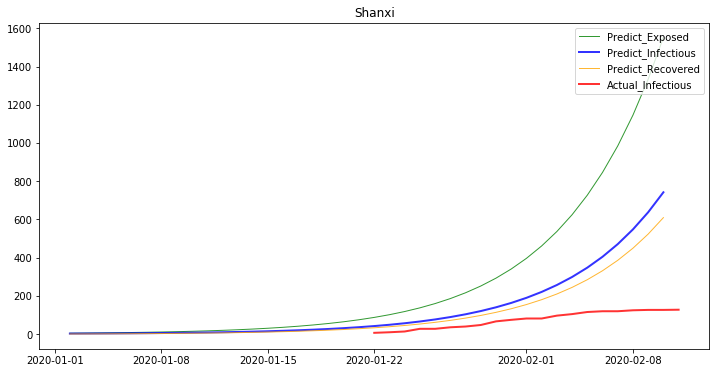

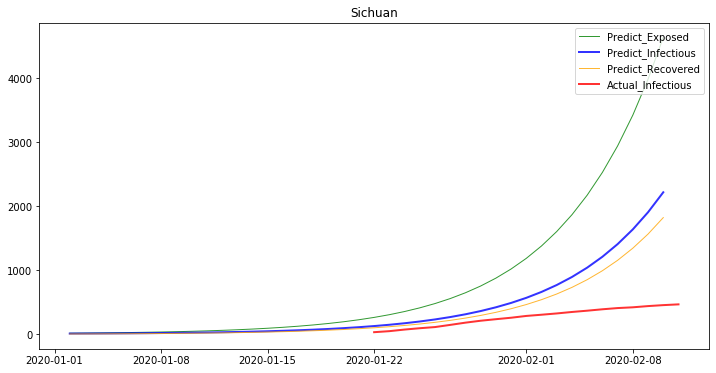

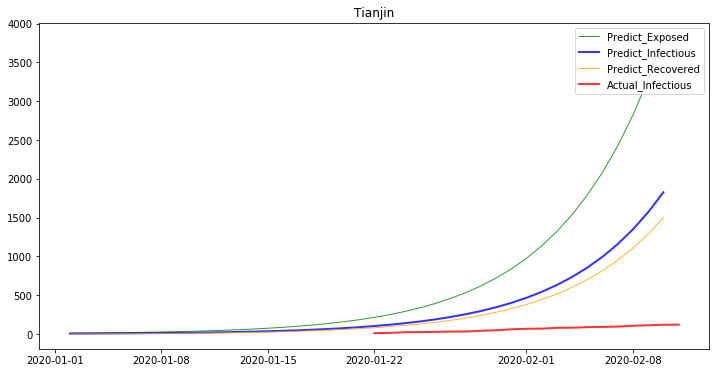

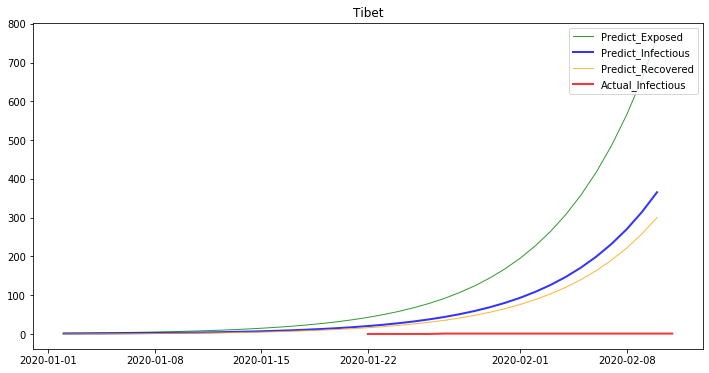

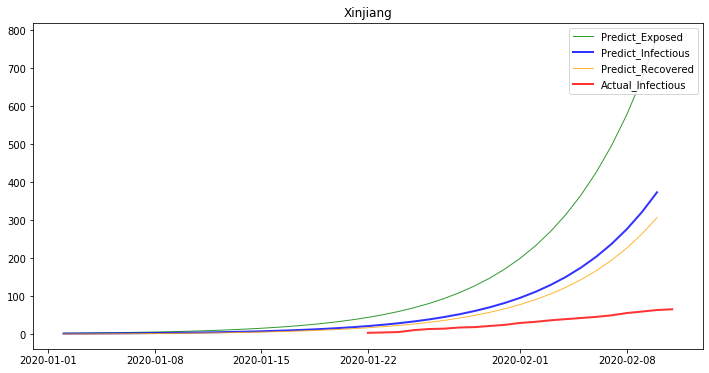

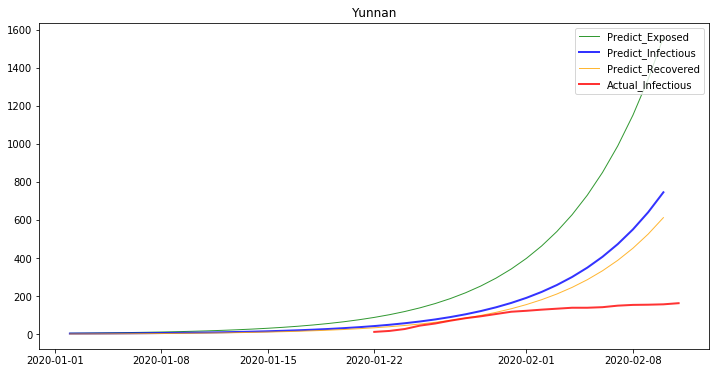

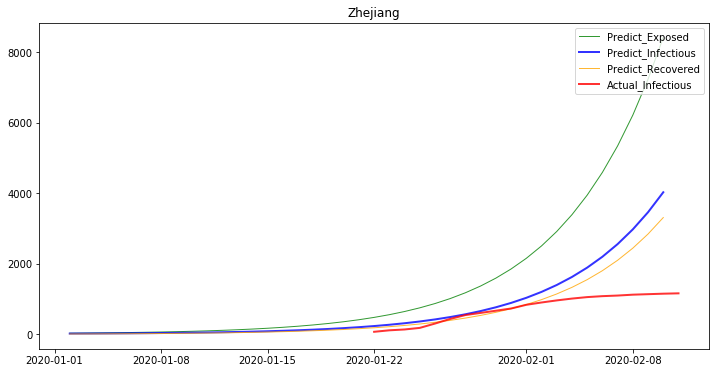

In [22]:
#plot all province
provinces=jhkDF['province_en'].unique()
for province in provinces:
    try:
        SEIR(jhkDF,province)
    except:
        print("does not exist")
    

##### III. Use Hubei data to estimate how many infected get into other cities before Jan. 22 
* sum(K_hubei_city(t)/hubei_population)*I_hubei
* Not done